In [ ]:
# default_exp data.preparation

# Data preparation

> Functions required to prepare X (and y) from a pandas dataframe.

In [ ]:
#export
from tsai.imports import *
from tsai.utils import *
from tsai.data.validation import *

In [ ]:
#export
def df2Xy(df, sample_col=None, feat_col=None, data_cols=None, target_col=None, to3d=True, splits=None, sort_by=None, ascending=True, y_func=None):
    r"""
    This function allows you to transform a pandas dataframe into X and y numpy arrays that can be used to craete a TSDataset.
    sample_col: column that uniquely identifies each sample.
    feat_col: used for multivariate datasets. It indicates which is the column that indicates the feature by row.
    data_col: indicates ths column/s where the data is located. If None, it means all columns (except the sample_col, feat_col, and target_col)
    target_col: indicates the column/s where the target is.
    to3d: turns X to 3d (including univariate time series)
    sort_by: used to indicate how to sort the dataframe.
    y_func: function used to calculate y for each sample (and target_col)
    """
    if feat_col is not None:
        assert sample_col is not None, 'You must pass a sample_col when you pass a feat_col'

    passed_cols = []
    sort_cols = []
    if sort_by is not None:
        if isinstance(sort_by, pd.core.indexes.base.Index): sort_by = sort_by.tolist()
        sort_cols += listify(sort_by)
    if sample_col is not None:
        if isinstance(sample_col, pd.core.indexes.base.Index): sample_col = sample_col.tolist()
        sample_col = listify(sample_col)
        sort_cols += listify(sample_col)
        passed_cols += sample_col
    if feat_col is not None:
        if isinstance(feat_col, pd.core.indexes.base.Index): feat_col = feat_col.tolist()
        feat_col = listify(feat_col)
        sort_cols += listify(feat_col)
        passed_cols += feat_col
    if data_cols is not None:
        if isinstance(data_cols, pd.core.indexes.base.Index): data_cols = data_cols.tolist()
        data_cols = listify(data_cols)
    if target_col is not None:
        if isinstance(target_col, pd.core.indexes.base.Index): target_col = target_col.tolist()
        target_col = listify(target_col)
        passed_cols += target_col

    if data_cols is None:
        data_cols = [col for col in df.columns if col not in passed_cols]
    if sort_cols:
        df.sort_values(sort_cols, ascending=ascending, inplace=True)

    # X
    X = df.loc[:, data_cols].values
    if X.dtype == 'O':
        X = X.astype(np.float32)
    if sample_col is not None:
        unique_ids = df[sample_col[0]].unique().tolist()
        n_samples = len(unique_ids)
    else:
        unique_ids = np.arange(len(df)).tolist()
        n_samples = len(df)
    if feat_col is not None:
        n_feats = df[feat_col[0]].nunique()
        X = X.reshape(n_samples, n_feats, -1)
    elif to3d:
        X = X.reshape(n_samples, 1, -1)

    # y
    if target_col is not None:
        if sample_col is not None: 
            y = []
            for tc in target_col:
                _y = np.concatenate(df.groupby(sample_col)[tc].apply(np.array).reset_index()[tc]).reshape(n_samples, -1)
                if y_func is not None: _y = y_func(_y)
                y.append(_y)
            y = np.concatenate(y, -1)
        else: 
            y = df[target_col].values
        y = np.squeeze(y)
    else:
        y = None

    # Output
    if splits is None: return X, y
    else: return split_xy(X, y, splits)
    

def split_Xy(X, y=None, splits=None):
    if splits is None: 
        if y is not None: return X, y
        else: return X
    if not is_listy(splits[0]): splits = [splits]
    else: assert not is_listy(splits[0][0]), 'You must pass a single set of splits.'
    _X = []
    _y = []
    for split in splits:
        _X.append(X[split])
        if y is not None: _y.append(y[split])
    if len(splits) == 1: return _X[0], _y[0]
    elif len(splits) == 2: return _X[0], _y[0], _X[1], _y[1]
    elif len(splits) == 3: return _X[0], _y[0], _X[1], _y[1], _X[2], _y[2]
    
df2xy = df2Xy
split_xy = split_Xy

In [ ]:
n_samples = 1_000
n_rows = 10_000

sample_ids = np.arange(n_samples).repeat(n_rows//n_samples).reshape(-1,1)
feat_ids = np.tile(np.arange(n_rows // n_samples), n_samples).reshape(-1,1)
cont = np.random.randn(n_rows, 6)
ind_cat = np.random.randint(0, 3, (n_rows, 1))
target = np.array(['a', 'b', 'c'])[ind_cat]
ind_cat2 = np.random.randint(0, 3, (n_rows, 1))
target2 = np.array(['a', 'b', 'c'])[ind_cat2]
data = np.concatenate([sample_ids, feat_ids, cont, target, target], -1)
columns = ['sample_id', 'feat_id'] + (np.arange(6) + 1).astype(str).tolist() + ['target'] + ['target2']
df = pd.DataFrame(data, columns=columns)
idx = np.random.choice(np.arange(len(df)), len(df), False)
new_dtypes = {'sample_id':np.int32, 'feat_id':np.int32, '1':np.float32, '2':np.float32, '3':np.float32, '4':np.float32, '5':np.float32, '6':np.float32}
df = df.astype(dtype=new_dtypes)
df = df.loc[idx].reset_index(drop=True)
df

,sample_id,feat_id,1,2,3,4,5,6,target,target2
0,915,4,-1.360003,1.498529,0.483889,0.076380,1.313898,1.209177,c,c
1,54,8,-2.170919,0.619842,1.230493,0.732896,0.452333,2.977231,c,c
2,803,8,-1.626732,0.934001,-1.262737,0.107555,0.448379,1.605305,c,c
3,747,9,0.527584,-1.586991,-0.994099,-1.551326,-0.235878,0.010780,c,c
4,542,2,-0.121319,-1.267815,-2.692272,0.426934,-0.142434,0.318301,b,b
...,...,...,...,...,...,...,...,...,...,...
9995,113,5,-0.068309,1.469781,2.608069,-0.077965,-0.810713,0.548156,c,c
9996,70,4,-1.687354,-1.539154,-0.350997,-0.051386,-0.307650,-0.378541,b,b
9997,432,6,-0.416184,-1.015158,0.165251,0.365006,0.315408,-2.881720,c,c
9998,617,4,1.082779,-3.020131,-0.369546,-0.549992,0.281327,0.032137,a,a


In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', data_cols=['1', '2', '3', '4', '5', '6'], target_col=['target'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000,))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target']].values).mode), y[rand_idx])

In [ ]:
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='feat_id', target_col=['target', 'target2'], y_func=y_func)
test_eq(X.shape, (1000, 10, 6))
test_eq(y.shape, (1000, 2))
rand_idx = np.random.randint(0, np.max(df.sample_id))
sorted_df = df.sort_values(by=['sample_id', 'feat_id']).reset_index(drop=True)
test_eq(X[rand_idx], sorted_df[sorted_df.sample_id == rand_idx][['1', '2', '3', '4', '5', '6']].values)
test_eq(np.squeeze(scipy.stats.mode(sorted_df[sorted_df.sample_id == rand_idx][['target', 'target2']].values).mode), y[rand_idx])

In [ ]:
# Univariate
from io import StringIO
TESTDATA = StringIO("""sample_id;value_0;value_1;target
    rob;2;3;hot
    alice;6;7;lukewarm
    eve;11;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
X, y = df2Xy(df, sample_col='sample_id', target_col='target', data_cols=['value_0', 'value_1'], sort_by='sample_id')
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3,))
X, y

,sample_id,value_0,value_1,target
0,rob,2,3,hot
1,alice,6,7,lukewarm
2,eve,11,12,cold


(array([[[ 6,  7]],
 
        [[11, 12]],
 
        [[ 2,  3]]]),
 array(['lukewarm', 'cold', 'hot'], dtype=object))

In [ ]:
# Univariate
TESTDATA = StringIO("""sample_id;timestep;values;target
    rob;1;2;hot
    alice;1;6;lukewarm
    eve;1;11;cold
    
    rob;2;3;hot
    alice;2;7;lukewarm
    eve;2;12;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', target_col='target', data_cols=['values'], sort_by='timestep', to3d=True, y_func=y_func)
test_eq(X.shape, (3, 1, 2))
test_eq(y.shape, (3, ))
print(X, y)

,sample_id,timestep,values,target
0,rob,1,2,hot
1,alice,1,6,lukewarm
2,eve,1,11,cold
3,rob,2,3,hot
4,alice,2,7,lukewarm
5,eve,2,12,cold


[[[ 6 11]]

 [[ 2  7]]

 [[12  3]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col='target', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3,))

,sample_id,trait,value_0,value_1,target
8,eve,yellow,11,12,cold
9,eve,green,10,11,cold
2,rob,blue,4,5,hot
4,alice,green,6,7,lukewarm
0,rob,green,2,3,hot
3,rob,red,5,6,hot
1,rob,yellow,3,4,hot
11,eve,red,13,14,cold
7,alice,red,9,10,lukewarm
6,alice,blue,8,9,lukewarm


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
# Multivariate, multi-label
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target1;target2
    rob;green;2;3;hot;good
    rob;yellow;3;4;hot;good
    rob;blue;4;5;hot;good
    rob;red;5;6;hot;good
    alice;green;6;7;lukewarm;good
    alice;yellow;7;8;lukewarm;good
    alice;blue;8;9;lukewarm;good
    alice;red;9;10;lukewarm;good
    eve;yellow;11;12;cold;bad
    eve;green;10;11;cold;bad
    eve;blue;12;12;cold;bad
    eve;red;13;14;cold;bad
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', target_col=['target1', 'target2'], data_cols=['value_0', 'value_1'], y_func=y_func)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, 2))
print(X, y)

,sample_id,trait,value_0,value_1,target1,target2
0,rob,green,2,3,hot,good
1,rob,yellow,3,4,hot,good
2,rob,blue,4,5,hot,good
3,rob,red,5,6,hot,good
4,alice,green,6,7,lukewarm,good
5,alice,yellow,7,8,lukewarm,good
6,alice,blue,8,9,lukewarm,good
7,alice,red,9,10,lukewarm,good
8,eve,yellow,11,12,cold,bad
9,eve,green,10,11,cold,bad


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] [['lukewarm' 'good']
 ['cold' 'bad']
 ['hot' 'good']]


In [ ]:
# Multivariate, unlabeled
TESTDATA = StringIO("""sample_id;trait;value_0;value_1;target
    rob;green;2;3;hot
    rob;yellow;3;4;hot
    rob;blue;4;5;hot
    rob;red;5;6;hot
    alice;green;6;7;lukewarm
    alice;yellow;7;8;lukewarm
    alice;blue;8;9;lukewarm
    alice;red;9;10;lukewarm
    eve;yellow;11;12;cold
    eve;green;10;11;cold
    eve;blue;12;12;cold
    eve;red;13;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
idx = np.random.choice(len(df), len(df), False)
df = df.iloc[idx]
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', data_cols=['value_0', 'value_1'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y, None)

,sample_id,trait,value_0,value_1,target
8,eve,yellow,11,12,cold
10,eve,blue,12,12,cold
4,alice,green,6,7,lukewarm
6,alice,blue,8,9,lukewarm
11,eve,red,13,14,cold
1,rob,yellow,3,4,hot
3,rob,red,5,6,hot
7,alice,red,9,10,lukewarm
9,eve,green,10,11,cold
5,alice,yellow,7,8,lukewarm


[[[ 8  9]
  [ 6  7]
  [ 9 10]
  [ 7  8]]

 [[12 12]
  [10 11]
  [13 14]
  [11 12]]

 [[ 4  5]
  [ 2  3]
  [ 5  6]
  [ 3  4]]] None


In [ ]:
TESTDATA = StringIO("""sample_id;trait;timestep;values;target
    rob;green;1;2;hot
    rob;yellow;1;3;hot
    rob;blue;1;4;hot
    rob;red;1;5;hot
    alice;green;1;6;lukewarm
    alice;yellow;1;7;lukewarm
    alice;blue;1;8;lukewarm
    alice;red;1;9;lukewarm
    eve;yellow;1;11;cold
    eve;green;1;10;cold
    eve;blue;1;12;cold
    eve;red;1;13;cold
    
    rob;green;2;3;hot
    rob;yellow;2;4;hot
    rob;blue;2;5;hot
    rob;red;2;6;hot
    alice;green;2;7;lukewarm
    alice;yellow;2;8;lukewarm
    alice;blue;2;9;lukewarm
    alice;red;2;10;lukewarm
    eve;yellow;2;12;cold
    eve;green;2;11;cold
    eve;blue;2;13;cold
    eve;red;2;14;cold
    """)

df = pd.read_csv(TESTDATA, sep=";")
display(df)
def y_func(o): return scipy.stats.mode(o, axis=1).mode
X, y = df2xy(df, sample_col='sample_id', feat_col='trait', sort_by='timestep', target_col='target', data_cols=['values'], y_func=y_func)
print(X, y)
test_eq(X.shape, (3, 4, 2))
test_eq(y.shape, (3, ))

,sample_id,trait,timestep,values,target
0,rob,green,1,2,hot
1,rob,yellow,1,3,hot
2,rob,blue,1,4,hot
3,rob,red,1,5,hot
4,alice,green,1,6,lukewarm
5,alice,yellow,1,7,lukewarm
6,alice,blue,1,8,lukewarm
7,alice,red,1,9,lukewarm
8,eve,yellow,1,11,cold
9,eve,green,1,10,cold


[[[ 8  6]
  [ 9  7]
  [12 10]
  [13 11]]

 [[ 4  2]
  [ 5  3]
  [ 9  7]
  [10  8]]

 [[13 11]
  [14 12]
  [ 5  3]
  [ 6  4]]] ['lukewarm' 'cold' 'hot']


In [ ]:
#export
# SlidingWindow vectorization is based on "Fast and Robust Sliding Window Vectorization with NumPy" by Syafiq Kamarul Azman
# https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5


def SlidingWindow(window_len:int, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                  get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                  sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True):

    """
    Applies a sliding window to a 1d or 2d input (np.ndarray, torch.Tensor or pd.DataFrame)
    
    Args:
        window_len      = length of lookback window
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """

    if horizon == 0: horizon_rng = np.array([0])
    elif is_listy(horizon): horizon_rng = np.array(horizon)
    elif isinstance(horizon, Integral): horizon_rng = np.arange(1, horizon + 1) if horizon > 0 else np.arange(horizon + 1, 1)
    min_horizon = min(horizon_rng)
    max_horizon = max(horizon_rng)
    _get_x = slice(None) if get_x is None else get_x.tolist() if isinstance(get_x, pd.core.indexes.base.Index) else [get_x] if not is_listy(get_x) else get_x
    _get_y = slice(None) if get_y is None else get_y.tolist() if isinstance(get_y, pd.core.indexes.base.Index) else [get_y] if not is_listy(get_y) else get_y
    if min_horizon <= 0 and y_func is None and get_y != [] and check_leakage: 
        assert get_x is not None and  get_y is not None and len([y for y in _get_y if y in _get_x]) == 0,  \
        'you need to change either horizon, get_x, get_y or use a y_func to avoid leakage'
    stride = ifnone(stride, window_len)

    def _inner(o):
        if not seq_first: o = o.T
        if isinstance(o, pd.DataFrame): 
            if sort_by is not None: o.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
            X = o.loc[:, _get_x].values if get_x is None or not isinstance(_get_x[0], Integral) else o.iloc[:, _get_x].values
            y = o.loc[:, _get_y].values if get_y is None or not isinstance(_get_y[0], Integral) else o.iloc[:, _get_y].values
        else:
            if isinstance(o, torch.Tensor): o = o.numpy()
            if o.ndim < 2: o = o[:, None]
            X = o[:, _get_x]
            y = o[:, _get_y]
        seq_len = len(X)
        X_max_time = seq_len - start - max_horizon - window_len + 1
        if X_max_time <= 0: return None, None
        X_sub_windows = (start + 
                         np.expand_dims(np.arange(window_len), 0) + # window len
                         np.expand_dims(np.arange(X_max_time, step=stride), 0).T) # # subwindows
        X = np.transpose(X[X_sub_windows], (0, 2, 1))   
        if y is not None and get_y != []:
            y_start = start + window_len - 1
            y_max_time = seq_len - y_start - max_horizon
            y_sub_windows = (y_start + 
                             np.expand_dims(horizon_rng, 0) + # horizon_rng
                             np.expand_dims(np.arange(y_max_time, step=stride), 0).T) # # subwindows
            y = y[y_sub_windows]
            if y_func is not None and len(y) > 0: 
                y = y_func(y)
            if y.ndim >= 2: 
                for d in np.arange(1, y.ndim)[::-1]:
                    if y.shape[d] == 1: y = np.squeeze(y, axis=d)
            if y.ndim == 3: 
                y = y.transpose(0, 2, 1)
            return X, y
        else: return X, None
    return _inner

SlidingWindowSplitter = SlidingWindow

In [ ]:
wl = 5
t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl)(t)
test_eq(X.shape[1:], (1, wl))
itemify(X,)

input shape: (10,)


(#5) [(array([[0, 1, 2, 3, 4]]),),(array([[1, 2, 3, 4, 5]]),),(array([[2, 3, 4, 5, 6]]),),(array([[3, 4, 5, 6, 7]]),),(array([[4, 5, 6, 7, 8]]),)]

In [ ]:
wl = 5
h = 1

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9)]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, horizon=h)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (10,)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, (2, ))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5
h = 2 # 2 or more

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=1, horizon=h, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), array([5, 6])), (array([[1, 2, 3, 4, 5]]), array([6, 7])), (array([[2, 3, 4, 5, 6]]), array([7, 8])), (array([[3, 4, 5, 6, 7]]), array([8, 9]))]


In [ ]:
wl = 5

t = np.arange(10).reshape(1, -1)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=3, horizon=1, get_y=None, seq_first=False)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (1, 10)
[(array([[0, 1, 2, 3, 4]]), 5), (array([[3, 4, 5, 6, 7]]), 8)]


In [ ]:
wl = 5
start = 3

t = np.arange(20)
print('input shape:', t.shape)
X, y = SlidingWindow(wl, stride=None, horizon=1, start=start)(t)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)
[(array([[3, 4, 5, 6, 7]]), 8), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[13, 14, 15, 16, 17]]), 18)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var'])
display(df)
X, y = SlidingWindow(wl, stride=1, horizon=1, get_y=None)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,var
0,0
1,1
2,2
3,3
4,4
5,5
6,6
7,7
8,8
9,9


[(array([[0, 1, 2, 3, 4]]), 5), (array([[1, 2, 3, 4, 5]]), 6), (array([[2, 3, 4, 5, 6]]), 7), (array([[3, 4, 5, 6, 7]]), 8), (array([[4, 5, 6, 7, 8]]), 9), (array([[5, 6, 7, 8, 9]]), 10), (array([[ 6,  7,  8,  9, 10]]), 11), (array([[ 7,  8,  9, 10, 11]]), 12), (array([[ 8,  9, 10, 11, 12]]), 13), (array([[ 9, 10, 11, 12, 13]]), 14), (array([[10, 11, 12, 13, 14]]), 15), (array([[11, 12, 13, 14, 15]]), 16), (array([[12, 13, 14, 15, 16]]), 17), (array([[13, 14, 15, 16, 17]]), 18), (array([[14, 15, 16, 17, 18]]), 19)]


In [ ]:
wl = 5

t = np.arange(20)
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=['var']).T
display(df)
X, y = SlidingWindow(wl, stride=None, horizon=1, get_y=None, seq_first=False)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (1, wl))
test_eq(items[0][1].shape, ())

input shape: (20,)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
var,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19


[(array([[0, 1, 2, 3, 4]]), 5), (array([[5, 6, 7, 8, 9]]), 10), (array([[10, 11, 12, 13, 14]]), 15)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), array([  5,  50, 500])), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), array([  6,  60, 600])), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), array([  7,  70, 700])), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), array([  8,  80, 800])), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), array([  9,  90, 900]))]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
display(df)
X, y = SlidingWindow(wl, horizon=1, get_y=0)(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars, wl))

input shape: torch.Size([10, 3])


,var_0,var_1,var_2
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[  0,   1,   2,   3,   4],
       [  0,  10,  20,  30,  40],
       [  0, 100, 200, 300, 400]]), 5), (array([[  1,   2,   3,   4,   5],
       [ 10,  20,  30,  40,  50],
       [100, 200, 300, 400, 500]]), 6), (array([[  2,   3,   4,   5,   6],
       [ 20,  30,  40,  50,  60],
       [200, 300, 400, 500, 600]]), 7), (array([[  3,   4,   5,   6,   7],
       [ 30,  40,  50,  60,  70],
       [300, 400, 500, 600, 700]]), 8), (array([[  4,   5,   6,   7,   8],
       [ 40,  50,  60,  70,  80],
       [400, 500, 600, 700, 800]]), 9)]


In [ ]:
wl = 5
n_vars = 3

t = (torch.stack(n_vars * [torch.arange(10)]).T * tensor([1, 10, 100]))
print('input shape:', t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(wl, horizon=1, get_x=columns[:-1], get_y='target')(df)
items = itemify(X, y)
print(items)
test_eq(items[0][0].shape, (n_vars-1, wl))
test_eq(items[0][1].shape, ())

input shape: torch.Size([10, 3])


,var_0,var_1,target
0,0,0,0
1,1,10,100
2,2,20,200
3,3,30,300
4,4,40,400
5,5,50,500
6,6,60,600
7,7,70,700
8,8,80,800
9,9,90,900


[(array([[ 0,  1,  2,  3,  4],
       [ 0, 10, 20, 30, 40]]), 500), (array([[ 1,  2,  3,  4,  5],
       [10, 20, 30, 40, 50]]), 600), (array([[ 2,  3,  4,  5,  6],
       [20, 30, 40, 50, 60]]), 700), (array([[ 3,  4,  5,  6,  7],
       [30, 40, 50, 60, 70]]), 800), (array([[ 4,  5,  6,  7,  8],
       [40, 50, 60, 70, 80]]), 900)]


(1000, 3)


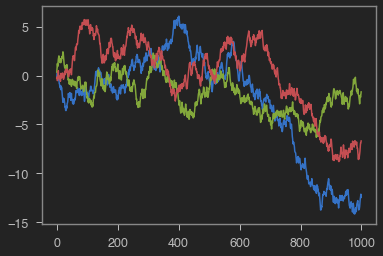

(200, 2, 5) (200,)


In [ ]:
n_vars = 3

t = (np.random.rand(1000, n_vars) - .5).cumsum(0)
print(t.shape)
plt.plot(t)
plt.show()
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=[0,1], get_y=2)(t)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

In [ ]:
wl = 5
n_vars = 3

t = (np.random.rand(100, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, horizon=0, get_x=columns[:-1], get_y='target')(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 3)


,var_0,var_1,target
0,0.168604,-0.292870,-0.219704
1,-0.127781,-0.128664,-0.552743
2,-0.369524,-0.119114,-0.661182
3,0.119771,-0.289242,-0.477067
4,-0.315121,-0.303987,-0.289793
...,...,...,...
95,-3.196447,0.257805,-2.061063
96,-3.546856,-0.163573,-2.171426
97,-3.584363,-0.333693,-2.351322
98,-3.271379,0.107681,-2.824138


(96, 2, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,var_0,var_1,var_2,var_3,target
0,0.057746,-0.354464,0.061742,-0.118709,0.245443
1,0.046304,-0.289984,-0.244740,-0.188395,0.571270
2,0.269671,-0.167975,-0.024407,-0.128858,0.971963
3,0.754259,0.312774,0.412286,0.057649,0.537707
4,0.503030,0.325545,0.090706,0.379620,0.357708
...,...,...,...,...,...
95,-1.161957,-2.636681,-0.827354,4.437652,3.767772
96,-1.100255,-2.371551,-0.493757,4.424497,3.280065
97,-1.266990,-1.896142,-0.239235,4.895432,3.420379
98,-1.185967,-1.675167,0.009557,5.250313,3.741320


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5

t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,0.357131,0.492757,0.077248,0.193362,0.108471,-0.280517,-0.763136,-0.290041,-0.403134,-0.061722,...,-3.134886,-2.649196,-2.457620,-2.954514,-2.526086,-2.144844,-2.001167,-2.201601,-2.398691,-2.635932
var_1,0.126680,0.146486,0.525572,0.545216,0.384825,0.127631,0.212632,-0.108968,-0.113096,0.361375,...,0.911728,1.243118,1.304361,0.891710,0.901517,0.790340,0.745191,0.570683,0.456578,0.757432
var_2,-0.175457,-0.422187,-0.833298,-1.211828,-0.805879,-1.121671,-1.057414,-0.630042,-0.790550,-0.564707,...,-0.770841,-0.723181,-1.174982,-0.693505,-0.730083,-0.420611,-0.233384,-0.452970,-0.014997,0.407039
var_3,0.310122,0.486644,0.197630,0.623839,0.645002,0.903100,0.883720,0.602154,0.243068,-0.012639,...,-2.065302,-2.248877,-2.550166,-2.248985,-2.349621,-2.422059,-2.124309,-2.408846,-2.608735,-3.095807
target,0.387990,0.501087,0.427327,0.174248,0.445185,0.523096,0.611663,0.418600,0.179848,0.488403,...,-0.844968,-0.625673,-1.001761,-0.969121,-0.471283,-0.921803,-0.783457,-0.867590,-1.336067,-1.292791


(96, 4, 5) (96,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)] + ['target']
df = pd.DataFrame(t, columns=columns).T
display(df)
X, y = SlidingWindow(5, stride=None, horizon=0, get_x=columns[:-1], get_y='target', seq_first=False)(df)
test_eq(X[0].shape, (n_vars-1, wl))
test_eq(y[0].shape, ())
print(X.shape, y.shape)

(100, 5)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
var_0,-0.369425,-0.859884,-0.695823,-0.977110,-1.472718,-1.827641,-1.874827,-2.167275,-2.646087,-2.541494,...,-2.770353,-3.007735,-2.939322,-3.045583,-2.685953,-2.326734,-2.756966,-2.831114,-2.468636,-2.745919
var_1,-0.106685,-0.333770,-0.368654,-0.858194,-0.969232,-0.832526,-1.049308,-0.677339,-1.053321,-0.748887,...,-1.097914,-1.387713,-1.194675,-1.471622,-1.008692,-0.947027,-0.818683,-0.760231,-0.604215,-0.584232
var_2,-0.470244,-0.609173,-0.657073,-0.932563,-0.639290,-0.323522,-0.438760,-0.593512,-0.568116,-0.340168,...,0.986673,0.921600,1.043679,0.702681,0.378758,0.800665,0.797671,0.525319,0.391468,0.012323
var_3,-0.080724,0.263277,0.323080,0.659323,1.147208,1.376134,1.332292,1.220342,1.067038,1.536942,...,-2.255563,-2.461494,-2.904639,-3.355843,-3.146533,-2.695644,-2.455526,-2.010123,-1.974566,-2.187884
target,-0.464664,-0.685932,-0.232545,-0.068022,0.330551,0.732091,0.352976,-0.066516,0.052011,-0.159056,...,-1.081015,-1.370162,-1.776511,-1.743151,-1.803415,-1.772434,-2.114774,-2.415698,-2.009574,-2.357681


(20, 4, 5) (20,)


In [ ]:
seq_len = 100
n_vars = 5
t = (np.random.rand(seq_len, n_vars) - .5).cumsum(0)
print(t.shape)
columns=[f'var_{i}' for i in range(n_vars-1)]+['target']
df = pd.DataFrame(t, columns=columns)
display(df)
X, y = SlidingWindow(5, stride=1, horizon=0, get_x=columns[:-1], get_y='target', seq_first=True)(df)
splits = TrainValidTestSplitter(valid_size=.2, shuffle=False)(y)
X.shape, y.shape, splits

(100, 5)


,var_0,var_1,var_2,var_3,target
0,-0.082335,-0.336678,0.316473,0.333184,-0.417955
1,0.263403,-0.238452,0.259514,0.488270,-0.645819
2,0.185497,0.168950,-0.142845,0.729862,-0.250218
3,0.627045,0.341772,-0.534462,0.847278,0.232249
4,0.777145,0.181826,-0.527025,1.228615,0.685599
...,...,...,...,...,...
95,-0.210707,-0.876872,-1.763892,4.460263,0.477580
96,-0.484621,-0.842980,-1.898047,4.959487,0.254949
97,-0.615424,-1.163492,-2.255340,5.243048,0.270977
98,-0.515153,-1.124679,-2.289444,5.119720,0.465985


((96, 4, 5),
 (96,),
 ((#77) [0,1,2,3,4,5,6,7,8,9...], (#19) [77,78,79,80,81,82,83,84,85,86...]))

In [ ]:
#export
def SlidingWindowPanel(window_len:int, unique_id_cols:list, stride:Union[None, int]=1, start:int=0, get_x:Union[None, int, list]=None,  
                       get_y:Union[None, int, list]=None, y_func:Optional[callable]=None, horizon:Union[int, list]=1, seq_first:bool=True, 
                       sort_by:Optional[list]=None, ascending:bool=True, check_leakage:bool=True, return_key:bool=False, verbose:bool=True):

    """
    Applies a sliding window to a pd.DataFrame.
    
    Args:
        window_len      = length of lookback window
        unique_id_cols  = pd.DataFrame columns that will be used to identify a time series for each entity.
        stride          = n datapoints the window is moved ahead along the sequence. Default: 1. If None, stride=window_len (no overlap)
        start           = determines the step where the first window is applied: 0 (default), a given step (int), or random within the 1st stride (None). 
        horizon         = number of future datapoints to predict:
                            * 0 for last step in each sub-window. 
                            * n > 0 for a range of n future steps (1 to n). 
                            * n < 0 for a range of n past steps (-n + 1 to 0).
                            * list : for those exact timesteps.
        get_x           = indices of columns that contain the independent variable (xs). If None, all data will be used as x.
        get_y           = indices of columns that contain the target (ys). If None, all data will be used as y. [] means no y data is created.
        y_func          = function to calculate the ys based on the get_y col/s and each y sub-window. y_func must be a function applied to axis=1!
        seq_first       = True if input shape (seq_len, n_vars), False if input shape (n_vars, seq_len)
        sort_by         = column/s used for sorting the array in ascending order
        ascending       = used in sorting
        check_leakage   = checks if there's leakage in the output between X and y
        return_key      = when True, the key corresponsing to unique_id_cols for each sample is returned
        
        
    Input:
        You can use np.ndarray, pd.DataFrame or torch.Tensor as input
        shape: (seq_len, ) or (seq_len, n_vars) if seq_first=True else (n_vars, seq_len)
    """
    
    sort_by = unique_id_cols + (sort_by if sort_by is not None else [])
    
    def _SlidingWindowPanel(df):
        
        df.sort_values(by=sort_by, axis=0, ascending=ascending, inplace=True, ignore_index=True)
        unique_id_values = df[unique_id_cols].drop_duplicates().values
        _x = []
        _y = []
        _key = []
        for v in progress_bar(unique_id_values, display=verbose, leave=False):
            x_v, y_v = SlidingWindow(window_len, stride=stride, start=start, get_x=get_x, get_y=get_y, y_func=y_func, 
                                     horizon=horizon, seq_first=seq_first, check_leakage=check_leakage)(df[(df[unique_id_cols].values == v).sum(axis=1) == len(v)])                                
            if x_v is not None and len(x_v) > 0: 
                _x.append(x_v)
                if return_key: _key.append([v.tolist()] * len(x_v))
                if y_v is not None and len(y_v) > 0: _y.append(y_v)
            else: pv(f'cannot use {unique_id_cols} = {v} due to not having enough records', verbose)

        X = np.concatenate(_x)
        if _y != []:
            y = np.concatenate(_y)
            for d in np.arange(1, y.ndim)[::-1]:
                if y.shape[d] == 1: y = np.squeeze(y, axis=d)
        else: y = None
        if return_key: 
            key = np.concatenate(_key)
            if key.ndim == 2 and key.shape[-1] == 1: key = np.squeeze(key, -1)
            if return_key: return X, y, key
        else: return X, y
        
    return _SlidingWindowPanel

SlidingWindowPanelSplitter = SlidingWindowPanel

In [ ]:
samples = 100_000
wl = 5
n_vars = 10

t = (torch.stack(n_vars * [torch.arange(samples)]).T * tensor([10**i for i in range(n_vars)]))
df = pd.DataFrame(t, columns=[f'var_{i}' for i in range(n_vars)])
df['time'] = np.arange(len(t))
df['device'] = 0
df['target'] = np.random.randint(0, 2, len(df))
df2 = df.copy()
df3 = df.copy()
cols = ['var_0', 'var_1', 'var_2', 'device', 'target']
df2[cols] = df2[cols] + 1
df3[cols] = df3[cols] + 2
df2 = df2.loc[:3]
df['region'] = 'A'
df2['region'] = 'A'
df3['region'] = 'B'
df = df.append(df2).append(df3).reset_index(drop=True)
df['index'] = np.arange(len(df))
df = df.sample(frac=1).reset_index(drop=True)
display(df.head())
df.shape

,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,var_9,time,device,target,region,index
0,1299,12990,129900,1299000,12990000,129900000,1299000000,12990000000,129900000000,1299000000000,1299,0,1,A,1299
1,27187,271870,2718700,27187000,271870000,2718700000,27187000000,271870000000,2718700000000,27187000000000,27187,0,0,A,27187
2,79121,791192,7911902,79119000,791190000,7911900000,79119000000,791190000000,7911900000000,79119000000000,79119,2,2,B,179123
3,7569,75672,756702,7567000,75670000,756700000,7567000000,75670000000,756700000000,7567000000000,7567,2,3,B,107571
4,33691,336892,3368902,33689000,336890000,3368900000,33689000000,336890000000,3368900000000,33689000000000,33689,2,2,B,133693


(200004, 15)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=False)(df)
X.shape, y.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
X, y, key = SlidingWindowPanel(window_len=5, unique_id_cols=['device'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                               horizon=0, seq_first=True, sort_by=['time'], ascending=True, return_key=True)(df)
X.shape, y.shape, key.shape

cannot use ['device'] = [1] due to not having enough records


((199992, 10, 5), (199992,), (199992,))

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          horizon=0, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199992, 10, 5), (199992,))

In [ ]:
# y_func must be a function applied to axis=1!
def y_max(o): return np.max(o, axis=1)

In [ ]:
X, y = SlidingWindowPanel(window_len=5, unique_id_cols=['device', 'region'], stride=1, start=0, get_x=df.columns[:n_vars], get_y=['target'], 
                          y_func=y_max, horizon=5, seq_first=True, sort_by=['time'], ascending=True)(df)
X.shape, y.shape

cannot use ['device', 'region'] = [1 'A'] due to not having enough records


((199982, 10, 5), (199982,))

In [ ]:
#hide
out = create_scripts(); beep(out)

<IPython.core.display.Javascript object>

Converted 000_utils.ipynb.
Converted 000b_data.validation.ipynb.
Converted 000c_data.preparation.ipynb.
Converted 001_data.external.ipynb.
Converted 002_data.core.ipynb.
Converted 002b_data.unwindowed.ipynb.
Converted 002c_data.metadatasets.ipynb.
Converted 003_data.preprocessing.ipynb.
Converted 003b_data.transforms.ipynb.
Converted 003c_data.mixed_augmentation.ipynb.
Converted 003d_data.image.ipynb.
Converted 003e_data.features.ipynb.
Converted 005_data.tabular.ipynb.
Converted 006_data.mixed.ipynb.
Converted 051_metrics.ipynb.
Converted 052_learner.ipynb.
Converted 052b_tslearner.ipynb.
Converted 053_optimizer.ipynb.
Converted 060_callback.core.ipynb.
Converted 061_callback.noisy_student.ipynb.
Converted 062_callback.gblend.ipynb.
Converted 063_callback.MVP.ipynb.
Converted 064_callback.PredictionDynamics.ipynb.
Converted 100_models.layers.ipynb.
Converted 100b_models.utils.ipynb.
Converted 100c_models.explainability.ipynb.
Converted 101_models.ResNet.ipynb.
Converted 101b_models.Re